In [1]:
#Uses the full matrix - not upper triangular matrix
# Output: (K*1) vector that predicts whether each of the K possible locations of the AP will have LOS with the current new client.

#While testing, 0s are preferred as the new LOS element. See test_next_batch(). Search for #preferZerosHere

from __future__ import print_function

import numpy as np
##Tensorflow compatibility - do not use version 2
import tensorflow as tf

import random
from random import shuffle


from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

/home/shyam/anaconda3/envs/ml_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shyam/anaconda3/envs/ml_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shyam/anaconda3/envs/ml_gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shyam/anaconda3/envs/ml_gpu/lib/python3.7/s

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.test.gpu_device_name())
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

1.13.2
True
/device:GPU:0


#### Metrics used for testing performance

For the case when the new known LOS element between the new STA and current AP location is used as part of input features:

$$ metric\_all\_all = \frac{\text{Total correct predictions (0 and 1)}}{\text{Total test case input count}}$$
$$ metric\_all\_0 = \frac{\text{Total correct predictions (0 and 1) when test input is 0}}{\text{Total test case input count when test input is 0}}$$

$$ metric\_1\_0 = \frac{\text{Total correct predictions (1's only) when test input is 0}}{\text{Total test case inputs (1's only) when test input is 0}}$$



In [4]:
###### Parameters

n_clients = 6  # or 6, 11, 21
n_AP_locations = 31

#Using dataset with only distance, hop distance, and STA connectivity matrices. Contains simulated errors
exp = 'feb17_200locations/'    #correlated
#exp = 'Distance_and_Hop_Distance/data-with-error/40percent/'    #Only data for 6 clients

#################################################
# Parameters to tweak

flag_AP_STA_LOS = True          #True if the STA-AP LOS matrix is included as input
flag_los = True     #True if using sta-sta LOS 
flag_sta_sta_hopDist = False #True if using hop distance between sta-sta
flag_sta_sta_dist = False    # True if using distance matrix between sta-sta
flag_STA_Location = False   #True if location of STAs are used
flag_oneLocation = True     #True if the one known AP location for known STA - AP LOS element is included
flag_oneLocation_LOS = True #True if the one known STA - AP LOS element is included
flag_sequential_data = False    #True if you want to separate training and testing data in time- testing data occurs after training data in time
flag_trainWithOnly0LOS = True    #True if you want to train with only the samples which have current_STA-current_AP_Location LOS =0


#Testing Flags##################################Begin
flag_preferZerosTesting = True    #If True, Zeros will be picked as new LOS input if present.

#Testing Flags##################################End

train_split = 0.7    #was 0.7################
learning_rate_init = 0.2   #was 0.1
training_epochs = 50000   #was 1 million
batch_size = 256  #was 256

# Network Parameters
n_hidden_1 = 1024 # 1st layer number of neurons
n_hidden_2 = 512 # 2nd layer number of neurons
# n_hidden_3 = 256 # 3rd layer number of neurons 
# n_hidden_4 = 256
# n_hidden_5 = 64
#################################################

flag_AP_location_vector = False

flag_plot = True    #To enable plots 
flag_31pts = True   #Keep as true

flag_limitTimeSteps = False    #Use when only a certain number of data points are required
timeStepsToTrain = 5000         #Has effect only when flag_limitTimeSteps is True


learning_rate_iter = 1000
learning_rate_decay = 0.9


display_train_step = 100
display_test_step = 1000




n_features = 0
if flag_AP_STA_LOS:
    n_features +=((n_clients - 1) * 31 )
if flag_los:
    n_features +=n_clients*n_clients 

if flag_AP_location_vector:
    n_features += n_AP_locations
if flag_STA_Location:
    n_features += n_clients*3
if flag_sta_sta_hopDist:
    n_features +=n_clients*n_clients 
if flag_sta_sta_dist:
    n_features +=n_clients*n_clients 
if flag_oneLocation:
     n_features += 1
if flag_oneLocation_LOS:
     n_features += 1

n_output = 31 if flag_31pts else 1
loc_idx = None if flag_31pts else 0

print("Number of input Features: " + str(n_features))

Number of input Features: 193


In [5]:
# Commented out code

#Using new dataset with Location - this is the latest data
#--------------------------------------------

#exp = 'data/withLocation/data/data-sta-no/c21/'
#exp = 'data/withLocation/data_with_errors/data-sta-no/c21/'
#exp = 'data/withLocation/data_with_errors/data-obs-den/60p/'
#exp = 'data/withLocation/data_with_errors/data-obs-map/map3/'

#--------------------------------------------


#If using the new dataset from 100*100 STAs
#------------------------------------------
#For 40% obstacle density
# if n_clients == 21:
#     exp = 'data/obs40percent/c21/'
# elif n_clients == 11:
#     exp = 'data/obs40percent/c11/'   
# elif n_clients == 6:
#     exp = 'data/obs40percent/c6/'   
#------------------------------------------

# #For Different obstacle densities - only 21 STAs
# #------------------------------------------

#exp = 'data/data-obs-densityAndMap/data-obs-den/20percent/'



# #------------------------------------------


# #For the older datasets
# #------------------------------------------
# if n_clients == 21:
#     exp = 'data/c41-om1/'    #Has been replaced with data for 21 clients - new dataset - correlated - obstacle density = 43
# # elif n_clients == 21:
# #     exp = 'data/c21-om2/'
# elif n_clients == 5:
#     exp = 'data/c6-om1/'
# elif n_clients == 6:
#     exp = 'data/c6-om1/'    #Old dataset with higher obstacle density
# # elif n_clients == 6:
# #     exp = 'data/c6-obs11-3380/'    #New dataset with reduced obstacle density

# #------------------------------------------

In [6]:
## Importing Data

los_sta_sta = np.load(exp+'los_sta_sta.npy')  # data_points x n_clients x n_clients
los_ap_sta = np.load(exp+'los_ap_sta.npy').transpose(0,2,1)  # data_points x n_clients x possible_AP_pos
#
#dis_ap_sta = np.load(exp+'dis_ap_sta.npy').transpose(0,2,1)  # data_points x n_clients x possible_AP_pos
if flag_STA_Location:
    sta_loc = np.load(exp + 'loc_sta.npy')

if flag_sta_sta_dist:
    dis_sta_sta = np.load(exp+'dis_sta_sta.npy')  # data_points x n_clients x n_clients
if flag_sta_sta_hopDist:
    hopDist_sta = np.load(exp+'hop_sta_sta.npy')
if flag_limitTimeSteps:
    total_data_points = timeStepsToTrain
    los_sta_sta = los_sta_sta[0:timeStepsToTrain ,:,:]
    los_ap_sta = los_ap_sta[0:timeStepsToTrain  , : , :]
    sta_loc = sta_loc[0:timeStepsToTrain  , : , :]
    dis_sta_sta = dis_sta_sta[0:timeStepsToTrain  , : , :]
    hopDist_sta = hopDist_sta[0:timeStepsToTrain  , : , :]
else:
    total_data_points = los_sta_sta.shape[0]
       
# print(dis_sta_sta.shape)
# print(hopDist_sta.shape)
# print(dis_sta_sta[3000:3010,:,:])
#print(hopDist_sta[3000:3010,:,:])
print(total_data_points)

x = np.sum(los_ap_sta)*1.0/los_ap_sta.size
pos_weight = (1-x)/x
#print(pos_weight)


if flag_sequential_data:
    trainDataLimit = int(train_split * total_data_points)
    train_losSS = los_sta_sta[0:trainDataLimit,:,:]
    train_losAS = los_ap_sta[0:trainDataLimit,:,:]
    test_losSS = los_sta_sta[trainDataLimit:,:,:]
    test_losAS = los_ap_sta[trainDataLimit:,:,:]
else:
    rnd_indices = np.random.rand(total_data_points) < train_split
    train_losSS = los_sta_sta[rnd_indices,:,:]
    train_losAS = los_ap_sta[rnd_indices,:,:]
    test_losSS = los_sta_sta[~rnd_indices,:,:]
    test_losAS = los_ap_sta[~rnd_indices,:,:]


if flag_STA_Location:
    train_sta_loc = sta_loc[rnd_indices,:,:]
    test_sta_loc = sta_loc[~rnd_indices,:,:]
    norm_mean_locX = np.mean(train_sta_loc[:,:,0])
    norm_mean_locY = np.mean(train_sta_loc[:,:,1])
    norm_mean_locZ = np.mean(train_sta_loc[:,:,2])
    norm_std_locX = np.std(train_sta_loc[:,:,0])
    norm_std_locY = np.std(train_sta_loc[:,:,1])
    norm_std_locZ = np.std(train_sta_loc[:,:,2])
if flag_sta_sta_dist:
    train_dis_sta_sta = dis_sta_sta[rnd_indices,:,:]
    test_dis_sta_sta = dis_sta_sta[~rnd_indices,:,:]
    norm_mean_dis_sta_sta = np.mean(train_dis_sta_sta)
    norm_std_dis_sta_sta = np.std(train_dis_sta_sta)
    #Normalizing both training and test data here
    train_dis_sta_sta = (train_dis_sta_sta[:,:,:] - norm_mean_dis_sta_sta)/norm_std_dis_sta_sta
    test_dis_sta_sta = (test_dis_sta_sta[:,:,:] - norm_mean_dis_sta_sta)/norm_std_dis_sta_sta
    #print(train_dis_sta_sta)
    
if flag_sta_sta_hopDist:
    train_hopDist_sta = hopDist_sta[rnd_indices,:,:]
    test_hopDist_sta = hopDist_sta[~rnd_indices,:,:]
    norm_mean_hopDist_sta = np.mean(train_hopDist_sta)
    norm_std_hopDist_sta = np.std(train_hopDist_sta)
    #Normalizing both training and test data here
    train_hopDist_sta = (train_hopDist_sta[:,:,:] - norm_mean_hopDist_sta)/norm_std_hopDist_sta
    test_hopDist_sta = (test_hopDist_sta[:,:,:] - norm_mean_hopDist_sta)/norm_std_hopDist_sta
    #print(norm_mean_hopDist_sta, norm_std_hopDist_sta)

total_train_points = train_losSS.shape[0]
total_test_points = test_losSS.shape[0]
print(total_train_points)
print(total_test_points)

10000
6973
3027


In [7]:
##### Building the NN Graph

# tf Graph input
X = tf.placeholder("float", [None, n_features])
Y = tf.placeholder("float", [None, n_output])
learning_rate = tf.Variable(learning_rate_init, trainable=False)

initializer = tf.contrib.layers.xavier_initializer()
h0 = tf.layers.dense(X, n_hidden_1, activation=tf.nn.relu, kernel_initializer=initializer)

#h0 = tf.nn.dropout(h0, 0.8)
h1 = tf.layers.dense(h0, n_hidden_2, activation=tf.nn.relu, kernel_initializer=initializer)
#h1 = tf.nn.dropout(h1, 0.8)
#h2 = tf.layers.dense(h1, n_hidden_3, activation=tf.nn.relu, kernel_initializer=initializer)
#h2 = tf.nn.dropout(h2, 0.8)
#h3 = tf.layers.dense(h2, n_hidden_4, activation=tf.nn.relu, kernel_initializer=initializer)
# h3 = tf.nn.dropout(h3, 0.8)
out = tf.layers.dense(h1, n_output, activation=None)

cross_entropy = tf.nn.weighted_cross_entropy_with_logits(targets=Y, logits=out, pos_weight=pos_weight)
cost = tf.reduce_mean(tf.reduce_mean(cross_entropy, axis=1)) # reduce_mean vs. reduce_sum

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
train_op = optimizer.minimize(cost)

predicted = tf.nn.sigmoid(out)
pred_labels = tf.round(predicted)    #Rounds to nearest integer
correct_pred = tf.equal(pred_labels, Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

new_learning_rate = tf.placeholder(tf.float32, shape=[])
learning_rate_update = tf.assign(learning_rate, new_learning_rate)    

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
def train_next_batch(batch_size):
    # Select samples of batch_size from training set
    batch_index = random.sample(range(total_train_points), batch_size)
    losSS = train_losSS[batch_index,:,:]
    losAS = train_losAS[batch_index,:,:]
    #disSS = train_disSS[batch_index,:,:]
    #disAS = train_disAS[batch_index,:,:]
    if flag_STA_Location:
        sta_loc_current = train_sta_loc[batch_index,:,:]
    if flag_sta_sta_dist:
        dis_sta_sta_current = train_dis_sta_sta[batch_index,:,:]
    if flag_sta_sta_hopDist:
        hopDist_sta_current = train_hopDist_sta[batch_index,:,:]
    
    # Random permutations 
    idx_shuffle = list(range(losSS.shape[1]))    #shape[1] corresponds to each STA
    #print(idx_shuffle)
    for idx in range(batch_size):
        shuffle(idx_shuffle)    #shuffles the array
        tmp = losSS[idx,idx_shuffle,:]    #Shuffles between STAs within one set of a batch - row wise
        tmp = tmp[:,idx_shuffle]          #shuffles column-wise for data consistency
        losSS[idx,:,:] = tmp
        losAS[idx,:,:] = losAS[idx,idx_shuffle,:]
        if flag_STA_Location:
            sta_loc_current[idx, : :] = sta_loc_current[idx,idx_shuffle,:]
        if flag_sta_sta_dist:     #already normalized
            tmp = dis_sta_sta_current[idx,idx_shuffle,:]    #Shuffles between STAs within one set of a batch - row wise
            tmp = tmp[:,idx_shuffle]          #shuffles column-wise for data consistency
            dis_sta_sta_current[idx,:,:] = tmp
        if flag_sta_sta_hopDist:     #already normalized
            tmp = hopDist_sta_current[idx,idx_shuffle,:]    #Shuffles between STAs within one set of a batch - row wise
            tmp = tmp[:,idx_shuffle]          #shuffles column-wise for data consistency
            hopDist_sta_current[idx,:,:] = tmp
        
    #normalizing the location
    if flag_STA_Location:
        X_locX = (sta_loc_current[:,:,0] - norm_mean_locX)/norm_std_locX
        X_locY = (sta_loc_current[:,:,1] - norm_mean_locY)/norm_std_locY
        X_locZ = (sta_loc_current[:,:,2] - norm_mean_locZ)/norm_std_locZ
  
    X1 = losSS.reshape((losSS.shape[0],(losSS.shape[1])*(losSS.shape[2])))
    if flag_sta_sta_dist:
        X_sta_sta_dist = dis_sta_sta_current.reshape((dis_sta_sta_current.shape[0],(dis_sta_sta_current.shape[1])*(dis_sta_sta_current.shape[2])))
    if flag_sta_sta_hopDist: 
        X_sta_sta_hopDist = hopDist_sta_current.reshape((hopDist_sta_current.shape[0],(hopDist_sta_current.shape[1])*(hopDist_sta_current.shape[2])))
    

    X2 = losAS[:,:-1,].reshape((losAS.shape[0],(losAS.shape[1]-1)*(losAS.shape[2])))    #leaving out the last client

    X1 = 2 * X1 - 1
    X2 = 2 * X2 - 1
    X = np.array([])
    if flag_AP_STA_LOS:
        X = X2 if (X.size==0) else np.concatenate((X, X1), axis =1)
    #print(X.shape)
    if flag_los:
        X= X1 if (X.size==0) else np.concatenate((X, X1), axis =1)

    if flag_AP_location_vector:
        tempVector1 = np.arange(0,31)/30
        tempVector2 = np.tile(tempVector1, (batch_size,1))
        X = np.concatenate((X, tempVector2 ), axis = 1)
    if flag_STA_Location:
        X = np.concatenate((X_locX, X_locY, X_locZ), axis = 1) if (X.size==0) else np.concatenate((X, X_locX, X_locY, X_locZ), axis = 1)
    if flag_sta_sta_dist:
        X =  X_sta_sta_dist if (X.size==0) else np.concatenate((X,X_sta_sta_dist), axis=1)
    if flag_sta_sta_hopDist:
        X =  X_sta_sta_hopDist if (X.size==0) else np.concatenate((X,X_sta_sta_hopDist), axis=1)

    Y = losAS[:,-1,:].reshape((batch_size,31))
    #print(f"X shape: {X.shape}, Y Shape: {Y.shape}")
    if flag_oneLocation or flag_oneLocation_LOS:
        tempArray1 = np.zeros([batch_size, 1])
        tempArray2 = np.zeros([batch_size, 1])
        randLoc =np.random.randint(31 , size=(batch_size)) 
        tempArray1[:,0] = (randLoc +1)/32.0
        for idx in range(batch_size):
            tempArray2[idx, 0] = 2*Y[idx,randLoc[idx]] -1
        #print(f"tempArray shape: {tempArray.shape}")
        #print(np.concatenate((X,tempArray), axis=1))
        if flag_oneLocation:
            X =  tempArray1 if (X.size==0) else np.concatenate((X,tempArray1), axis=1)
        if flag_oneLocation_LOS:
            X =  tempArray2 if (X.size==0) else np.concatenate((X,tempArray2), axis=1)
        #    print("X shape: "+ str(X.shape))

    return X, Y
    
def test_next_batch():
    # Select samples of batch_size from test set
#     batch_size = total_test_points
#     batch_index = random.sample(xrange(total_test_points), batch_size)
    losSS = test_losSS[:,:,:]
    losAS = test_losAS[:,:,:]
    #disSS = test_disSS[:,:,:]
    #disAS = test_disAS[:,:,:]
    if flag_STA_Location:
        sta_loc_current = test_sta_loc[:,:,:]
    if flag_sta_sta_dist:
        dis_sta_sta_current = test_dis_sta_sta[:,:,:]
    if flag_sta_sta_hopDist:
        hopDist_sta_current = test_hopDist_sta[:,:,:]
    if flag_STA_Location:
        X_locX = (sta_loc_current[:,:,0] - norm_mean_locX)/norm_std_locX
        X_locY = (sta_loc_current[:,:,1] - norm_mean_locY)/norm_std_locY
        X_locZ = (sta_loc_current[:,:,2] - norm_mean_locZ)/norm_std_locZ
        #print("locX shape for test:"  + str(X_locX.shape))
    
    #r,c = np.triu_indices(losSS.shape[1],1)
    
    #For the full matrix
    X1 = losSS.reshape((losSS.shape[0],(losSS.shape[1])*(losSS.shape[2])))
    X = np.array([])
    #For upper triangular matrix
    #X1 = losSS[:,r,c]
    X2 = losAS[:,:-1,].reshape((losAS.shape[0],(losAS.shape[1]-1)*(losAS.shape[2])))
    if flag_sta_sta_dist:
        X_sta_sta_dist = dis_sta_sta_current.reshape((dis_sta_sta_current.shape[0],(dis_sta_sta_current.shape[1])*(dis_sta_sta_current.shape[2])))
    if flag_sta_sta_hopDist: 
        X_sta_sta_hopDist = hopDist_sta_current.reshape((hopDist_sta_current.shape[0],(hopDist_sta_current.shape[1])*(hopDist_sta_current.shape[2])))
    

    #X3 = disSS[:,r,c]
    #X3 = (X3 - norm_mean_ss)/norm_std_ss
    #X4 = disAS[:,:-1,].reshape((disAS.shape[0],(disAS.shape[1]-1)*(disAS.shape[2])))
    #X4 = (X4 - norm_mean_as)/norm_std_as
    X1 = 2 * X1 - 1
    X2 = 2 * X2 - 1
    #XA = np.concatenate((X1,X2), axis=1)
    #XA = 2*XA - 1
    #XB = np.concatenate((X3,X4), axis=1)
    
    if flag_AP_STA_LOS:
        X = X2 if (X.size==0) else np.concatenate((X, X1), axis =1)

    #X = np.array([])
    if flag_los:
        X= X1 if (X.size==0) else np.concatenate((X, X1), axis =1)
        
    if flag_AP_location_vector:
        tempVector1 = np.arange(0,31)/30
        tempVector2 = np.tile(tempVector1, (X.shape[0],1)) 
        X = np.concatenate((X, tempVector2 ), axis = 1)
    if flag_STA_Location:
        X = np.concatenate((X_locX, X_locY, X_locZ), axis = 1) if (X.size==0) else np.concatenate((X, X_locX, X_locY, X_locZ), axis = 1)

    if flag_sta_sta_dist:
        X =  X_sta_sta_dist if (X.size==0) else np.concatenate((X,X_sta_sta_dist), axis=1)
    if flag_sta_sta_hopDist:
        X =  X_sta_sta_hopDist if (X.size==0) else np.concatenate((X,X_sta_sta_hopDist), axis=1)
    #print("X shape - test: "+ str(X.shape))
    Y = losAS[:,-1,:].reshape((total_test_points,31))  
    #print("Y shape - test: "+ str(Y.shape))
    if flag_oneLocation or flag_oneLocation_LOS:
        #preferZerosHere
        tempArray1 = np.zeros([total_test_points, 1])
        tempArray2 = np.zeros([total_test_points, 1])
        randLoc =np.random.randint(31 , size=(total_test_points)) 
        
        for idx in range(total_test_points):
            if (flag_preferZerosTesting):
                if np.sum(Y[idx,:]==0)==0:    #means there are no zeros in this vector
                    tempArray2[idx, 0] = 1 #setting it to one, duh
                    tempArray1[idx,0] = (randLoc[idx] +1)/32.0
                    #print(f"No zeros in test vector!!")
                else:
                    #there are zeros in this Y vector
                    tempArray2[idx, 0] = -1 #setting it to -1, duh
                    positions0 = np.where(Y[idx,:]==0)
                    #print(f"Shape of positions0: {positions0[0].shape}")
                    tempArray1[idx,0] = (np.random.choice(positions0[0])+1)/32.0  #Randomly picking one zero position
            else:
                #Picking zeros and ones alike
                tempArray1[idx,0] = (randLoc[idx] +1)/32.0
                tempArray2[idx, 0] = 2*Y[idx, randLoc[idx]] - 1

        #print(f"tempArray shape: {tempArray.shape}")
        #print(np.concatenate((X,tempArray), axis=1))
        if flag_oneLocation:
            X =  tempArray1 if (X.size==0) else np.concatenate((X,tempArray1), axis=1)
        if flag_oneLocation_LOS:
            X =  tempArray2 if (X.size==0) else np.concatenate((X,tempArray2), axis=1)
         
    return X, Y

<tf.Variable 'dense/kernel:0' shape=(193, 1024) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1024,) dtype=float32_ref>
step: 0, loss: 0.6868, Train Acc: 0.502
Correct Y[1290]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[1290]: [1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1.]

Validation Loss: 0.688   Accuracy(metric_all_all):  0.501 (0.501) , Precision: 0.493, Recall: 0.606
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.492  , Precision: 0.450, Recall: 0.606, metric_1_0 : 0.606
Validation Random Permutation Accuracy: 0.503


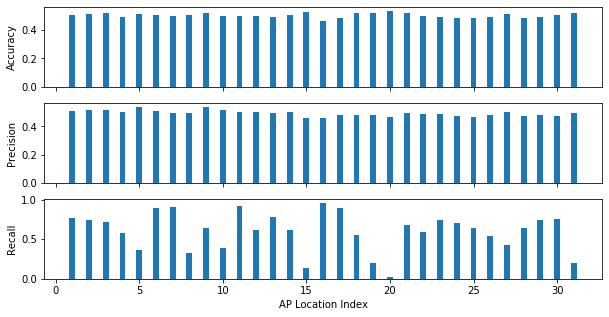

step: 1, loss: 0.6815, Train Acc: 0.506
step: 100, loss: 0.5402, Train Acc: 0.763
step: 200, loss: 0.4592, Train Acc: 0.821
step: 300, loss: 0.4510, Train Acc: 0.819
step: 400, loss: 0.4321, Train Acc: 0.832
step: 500, loss: 0.4358, Train Acc: 0.831
step: 600, loss: 0.4431, Train Acc: 0.826
step: 700, loss: 0.4115, Train Acc: 0.848
step: 800, loss: 0.4434, Train Acc: 0.826
step: 900, loss: 0.4456, Train Acc: 0.822
step: 1000, loss: 0.4258, Train Acc: 0.836
Learning rate:  [0.2]
Correct Y[89]: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[89]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.769   Accuracy(metric_all_all):  0.588 (0.588) , Precision: 0.999, Recall: 0.160


/home/shyam/anaconda3/envs/ml_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in double_scalars


Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.553  , Precision: 0.789, Recall: 0.001, metric_1_0 : 0.001
Validation Random Permutation Accuracy: 0.511


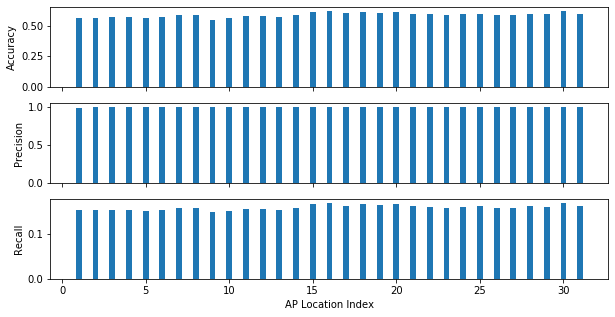

step: 1100, loss: 0.4185, Train Acc: 0.840
step: 1200, loss: 0.4875, Train Acc: 0.790
step: 1300, loss: 0.4603, Train Acc: 0.805
step: 1400, loss: 0.4492, Train Acc: 0.816
step: 1500, loss: 0.4406, Train Acc: 0.822
step: 1600, loss: 0.4311, Train Acc: 0.825
step: 1700, loss: 0.4759, Train Acc: 0.799
step: 1800, loss: 0.4555, Train Acc: 0.806
step: 1900, loss: 0.4536, Train Acc: 0.817
step: 2000, loss: 0.4628, Train Acc: 0.812
Learning rate:  [0.18]
Correct Y[2486]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[2486]: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]

Validation Loss: 0.742   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.998, Recall: 0.161
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.554  , Precision: 0.863, Recall: 0.003, metric_1_0 : 0.003
Validation Random Permutation Accuracy: 0.504


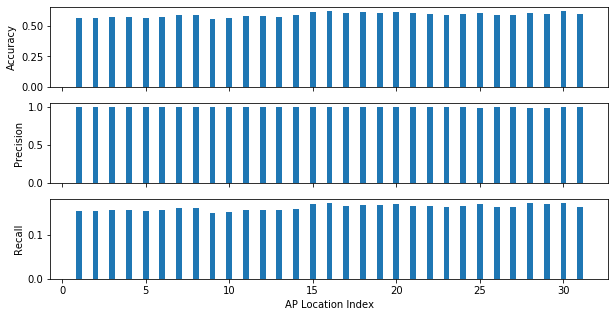

step: 2100, loss: 0.4509, Train Acc: 0.818
step: 2200, loss: 0.4791, Train Acc: 0.795
step: 2300, loss: 0.4699, Train Acc: 0.804
step: 2400, loss: 0.4090, Train Acc: 0.842
step: 2500, loss: 0.4120, Train Acc: 0.842
step: 2600, loss: 0.4361, Train Acc: 0.829
step: 2700, loss: 0.4426, Train Acc: 0.816
step: 2800, loss: 0.4622, Train Acc: 0.811
step: 2900, loss: 0.4234, Train Acc: 0.829
step: 3000, loss: 0.4345, Train Acc: 0.827
Learning rate:  [0.162]
Correct Y[1965]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[1965]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.761   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.998, Recall: 0.161
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.554  , Precision: 0.853, Recall: 0.003, metric_1_0 : 0.003
Validation Random Permutation Accuracy: 0.500


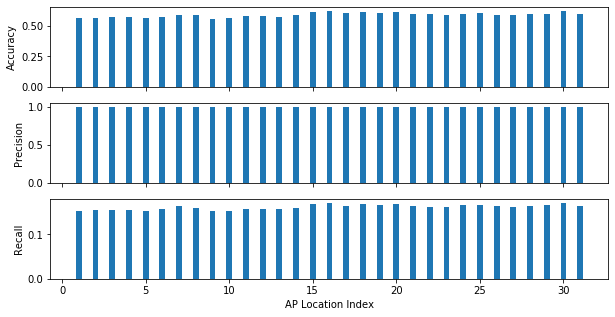

step: 3100, loss: 0.4464, Train Acc: 0.814
step: 3200, loss: 0.4631, Train Acc: 0.793
step: 3300, loss: 0.4216, Train Acc: 0.827
step: 3400, loss: 0.4484, Train Acc: 0.818
step: 3500, loss: 0.4226, Train Acc: 0.832
step: 3600, loss: 0.4637, Train Acc: 0.798
step: 3700, loss: 0.4389, Train Acc: 0.819
step: 3800, loss: 0.4439, Train Acc: 0.823
step: 3900, loss: 0.4291, Train Acc: 0.826
step: 4000, loss: 0.4404, Train Acc: 0.824
Learning rate:  [0.1458]
Correct Y[2472]: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
Predicted Y[2472]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.776   Accuracy(metric_all_all):  0.588 (0.588) , Precision: 1.000, Recall: 0.161
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.554  , Precision: 0.974, Recall: 0.002, metric_1_0 : 0.002
Validation Random Permutation Accuracy: 0.504


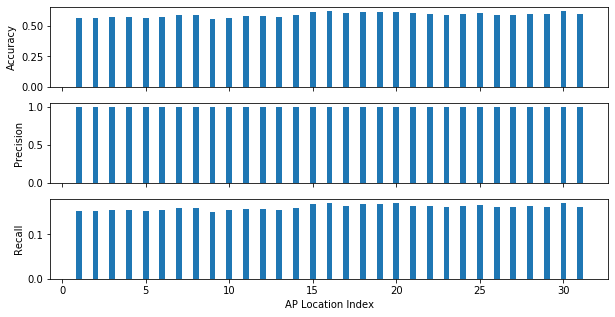

step: 4100, loss: 0.4282, Train Acc: 0.829
step: 4200, loss: 0.4625, Train Acc: 0.801
step: 4300, loss: 0.4151, Train Acc: 0.837
step: 4400, loss: 0.4167, Train Acc: 0.834
step: 4500, loss: 0.4962, Train Acc: 0.781
step: 4600, loss: 0.4219, Train Acc: 0.835
step: 4700, loss: 0.4488, Train Acc: 0.814
step: 4800, loss: 0.4352, Train Acc: 0.829
step: 4900, loss: 0.4090, Train Acc: 0.840
step: 5000, loss: 0.4452, Train Acc: 0.812
Learning rate:  [0.13122]
Correct Y[1676]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[1676]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.770   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.996, Recall: 0.163
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.873, Recall: 0.005, metric_1_0 : 0.005
Validation Random Permutation Accuracy: 0.508


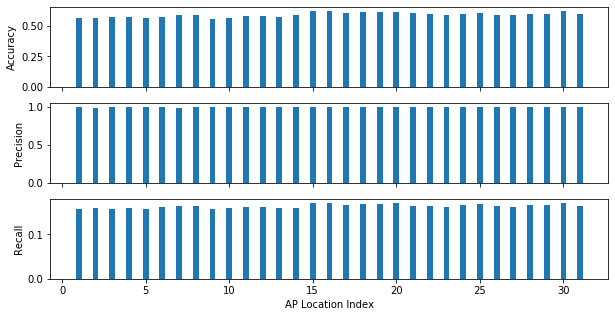

step: 5100, loss: 0.4309, Train Acc: 0.828
step: 5200, loss: 0.4551, Train Acc: 0.810
step: 5300, loss: 0.4447, Train Acc: 0.814
step: 5400, loss: 0.4436, Train Acc: 0.817
step: 5500, loss: 0.4678, Train Acc: 0.800
step: 5600, loss: 0.4522, Train Acc: 0.810
step: 5700, loss: 0.4471, Train Acc: 0.814
step: 5800, loss: 0.4217, Train Acc: 0.832
step: 5900, loss: 0.4304, Train Acc: 0.827
step: 6000, loss: 0.4323, Train Acc: 0.826
Learning rate:  [0.118098]
Correct Y[2051]: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[2051]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.763   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.996, Recall: 0.163
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.853, Recall: 0.005, metric_1_0 : 0.005
Validation Random Permutation Accuracy: 0.507


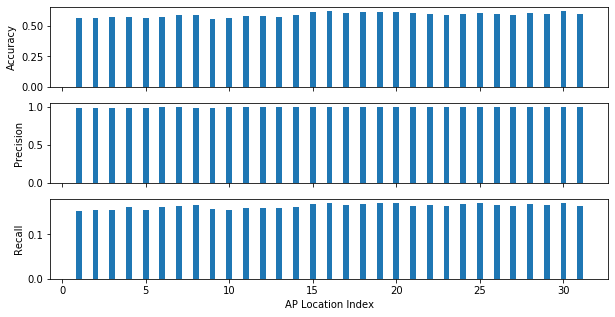

step: 6100, loss: 0.4321, Train Acc: 0.823
step: 6200, loss: 0.4536, Train Acc: 0.813
step: 6300, loss: 0.4475, Train Acc: 0.810
step: 6400, loss: 0.4448, Train Acc: 0.819
step: 6500, loss: 0.4436, Train Acc: 0.819
step: 6600, loss: 0.4227, Train Acc: 0.824
step: 6700, loss: 0.4473, Train Acc: 0.811
step: 6800, loss: 0.4342, Train Acc: 0.824
step: 6900, loss: 0.4045, Train Acc: 0.842
step: 7000, loss: 0.4510, Train Acc: 0.808
Learning rate:  [0.106288195]
Correct Y[2185]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[2185]: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]

Validation Loss: 0.753   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.993, Recall: 0.163
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.798, Recall: 0.005, metric_1_0 : 0.005
Validation Random Permutation Accuracy: 0.504


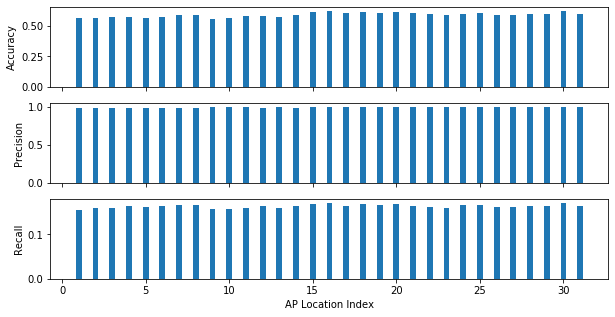

step: 7100, loss: 0.4313, Train Acc: 0.820
step: 7200, loss: 0.4119, Train Acc: 0.845
step: 7300, loss: 0.4637, Train Acc: 0.802
step: 7400, loss: 0.4320, Train Acc: 0.827
step: 7500, loss: 0.4371, Train Acc: 0.815
step: 7600, loss: 0.4653, Train Acc: 0.803
step: 7700, loss: 0.4397, Train Acc: 0.826
step: 7800, loss: 0.4184, Train Acc: 0.831
step: 7900, loss: 0.4485, Train Acc: 0.815
step: 8000, loss: 0.4802, Train Acc: 0.792
Learning rate:  [0.095659375]
Correct Y[1335]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[1335]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.780   Accuracy(metric_all_all):  0.589 (0.589) , Precision: 0.995, Recall: 0.164
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.839, Recall: 0.005, metric_1_0 : 0.005
Validation Random Permutation Accuracy: 0.507


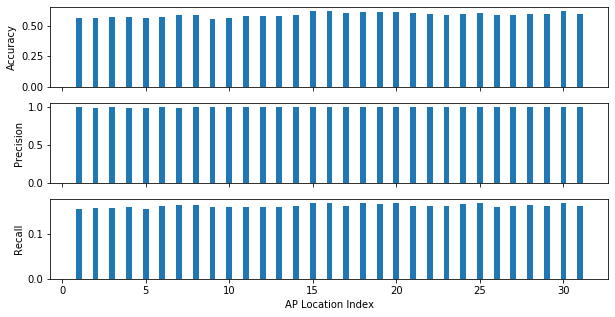

step: 8100, loss: 0.4183, Train Acc: 0.830
step: 8200, loss: 0.4507, Train Acc: 0.812
step: 8300, loss: 0.4472, Train Acc: 0.817
step: 8400, loss: 0.4265, Train Acc: 0.826
step: 8500, loss: 0.4594, Train Acc: 0.811
step: 8600, loss: 0.3858, Train Acc: 0.857
step: 8700, loss: 0.4433, Train Acc: 0.816
step: 8800, loss: 0.3919, Train Acc: 0.849
step: 8900, loss: 0.4053, Train Acc: 0.839
step: 9000, loss: 0.4265, Train Acc: 0.827
Learning rate:  [0.08609344]
Correct Y[1376]: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Predicted Y[1376]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.779   Accuracy(metric_all_all):  0.590 (0.590) , Precision: 0.993, Recall: 0.165
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.824, Recall: 0.007, metric_1_0 : 0.007
Validation Random Permutation Accuracy: 0.511


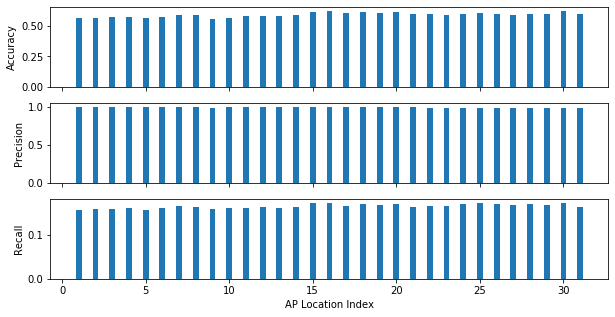

step: 9100, loss: 0.4212, Train Acc: 0.826
step: 9200, loss: 0.4280, Train Acc: 0.827
step: 9300, loss: 0.4439, Train Acc: 0.813
step: 9400, loss: 0.4574, Train Acc: 0.804
step: 9500, loss: 0.4273, Train Acc: 0.820
step: 9600, loss: 0.4312, Train Acc: 0.828
step: 9700, loss: 0.4279, Train Acc: 0.830
step: 9800, loss: 0.4542, Train Acc: 0.805
step: 9900, loss: 0.4530, Train Acc: 0.808
step: 10000, loss: 0.4485, Train Acc: 0.810
Learning rate:  [0.07748409]
Correct Y[337]: [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[337]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.772   Accuracy(metric_all_all):  0.590 (0.590) , Precision: 0.990, Recall: 0.166
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.555  , Precision: 0.806, Recall: 0.008, metric_1_0 : 0.008
Validation Random Permutation Accuracy: 0.506


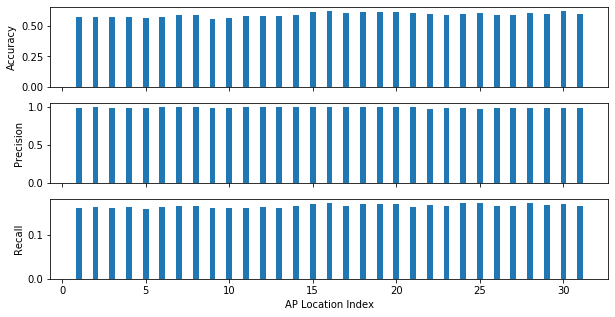

step: 10100, loss: 0.4240, Train Acc: 0.831
step: 10200, loss: 0.4288, Train Acc: 0.819
step: 10300, loss: 0.4402, Train Acc: 0.819
step: 10400, loss: 0.4690, Train Acc: 0.796
step: 10500, loss: 0.4199, Train Acc: 0.832
step: 10600, loss: 0.4436, Train Acc: 0.808
step: 10700, loss: 0.4122, Train Acc: 0.838
step: 10800, loss: 0.4465, Train Acc: 0.811
step: 10900, loss: 0.4600, Train Acc: 0.801
step: 11000, loss: 0.4689, Train Acc: 0.785
Learning rate:  [0.06973568]
Correct Y[920]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1]
Predicted Y[920]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.759   Accuracy(metric_all_all):  0.591 (0.591) , Precision: 0.991, Recall: 0.168
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.557  , Precision: 0.860, Recall: 0.011, metric_1_0 : 0.011
Validation Random Permutation Accuracy: 0.510


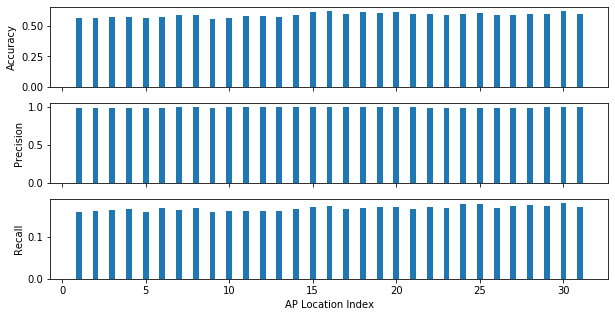

step: 11100, loss: 0.4310, Train Acc: 0.823
step: 11200, loss: 0.4198, Train Acc: 0.829
step: 11300, loss: 0.4419, Train Acc: 0.820
step: 11400, loss: 0.4573, Train Acc: 0.802
step: 11500, loss: 0.4058, Train Acc: 0.837
step: 11600, loss: 0.4738, Train Acc: 0.793
step: 11700, loss: 0.4138, Train Acc: 0.834
step: 11800, loss: 0.4167, Train Acc: 0.834
step: 11900, loss: 0.4091, Train Acc: 0.838
step: 12000, loss: 0.4113, Train Acc: 0.837
Learning rate:  [0.06276211]
Correct Y[1384]: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
Predicted Y[1384]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.760   Accuracy(metric_all_all):  0.591 (0.591) , Precision: 0.990, Recall: 0.167
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.556  , Precision: 0.822, Recall: 0.009, metric_1_0 : 0.009
Validation Random Permutation Accuracy: 0.510


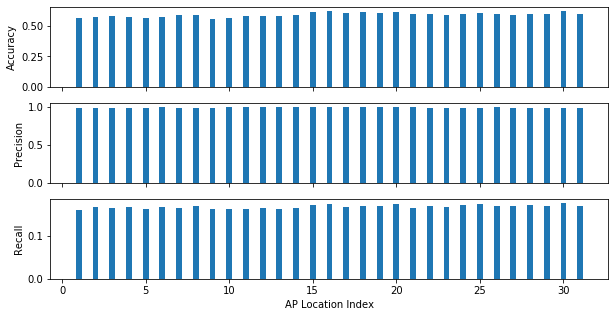

step: 12100, loss: 0.4204, Train Acc: 0.835
step: 12200, loss: 0.4072, Train Acc: 0.846
step: 12300, loss: 0.4362, Train Acc: 0.814
step: 12400, loss: 0.4250, Train Acc: 0.832
step: 12500, loss: 0.4451, Train Acc: 0.812
step: 12600, loss: 0.4333, Train Acc: 0.821
step: 12700, loss: 0.4358, Train Acc: 0.815
step: 12800, loss: 0.4667, Train Acc: 0.796
step: 12900, loss: 0.4081, Train Acc: 0.840
step: 13000, loss: 0.4386, Train Acc: 0.818
Learning rate:  [0.0564859]
Correct Y[1281]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
Predicted Y[1281]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.767   Accuracy(metric_all_all):  0.591 (0.591) , Precision: 0.986, Recall: 0.168
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.556  , Precision: 0.783, Recall: 0.010, metric_1_0 : 0.010
Validation Random Permutation Accuracy: 0.505


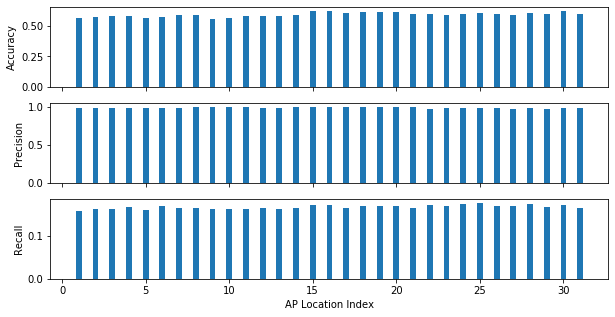

step: 13100, loss: 0.4166, Train Acc: 0.838
step: 13200, loss: 0.4558, Train Acc: 0.805
step: 13300, loss: 0.4414, Train Acc: 0.814
step: 13400, loss: 0.4159, Train Acc: 0.838
step: 13500, loss: 0.4189, Train Acc: 0.834
step: 13600, loss: 0.4353, Train Acc: 0.819
step: 13700, loss: 0.4666, Train Acc: 0.798
step: 13800, loss: 0.4320, Train Acc: 0.823
step: 13900, loss: 0.4395, Train Acc: 0.820
step: 14000, loss: 0.4068, Train Acc: 0.839
Learning rate:  [0.05083731]
Correct Y[1125]: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[1125]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.768   Accuracy(metric_all_all):  0.592 (0.592) , Precision: 0.991, Recall: 0.169
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.557  , Precision: 0.869, Recall: 0.012, metric_1_0 : 0.012
Validation Random Permutation Accuracy: 0.504


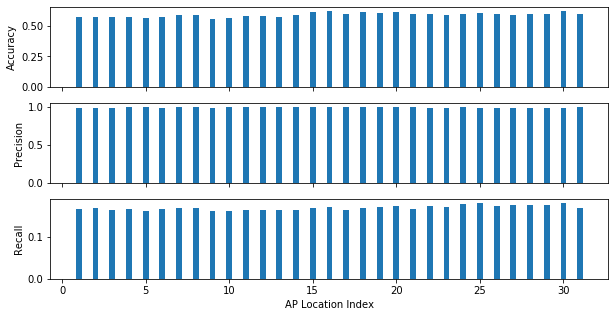

step: 14100, loss: 0.4560, Train Acc: 0.805
step: 14200, loss: 0.4449, Train Acc: 0.809
step: 14300, loss: 0.4518, Train Acc: 0.807
step: 14400, loss: 0.4187, Train Acc: 0.829
step: 14500, loss: 0.4475, Train Acc: 0.812
step: 14600, loss: 0.4334, Train Acc: 0.817
step: 14700, loss: 0.4560, Train Acc: 0.807
step: 14800, loss: 0.4624, Train Acc: 0.796
step: 14900, loss: 0.4290, Train Acc: 0.822
step: 15000, loss: 0.4384, Train Acc: 0.815
Learning rate:  [0.045753576]
Correct Y[790]: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[790]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.762   Accuracy(metric_all_all):  0.592 (0.592) , Precision: 0.987, Recall: 0.170
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.557  , Precision: 0.833, Recall: 0.013, metric_1_0 : 0.013
Validation Random Permutation Accuracy: 0.503


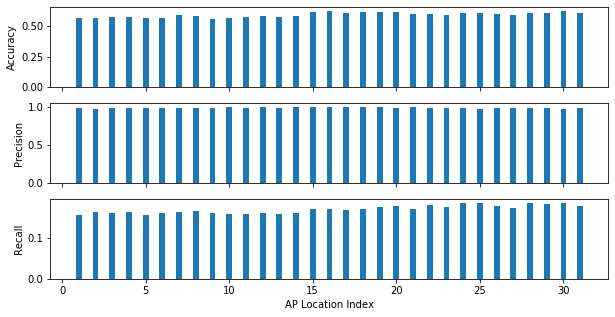

step: 15100, loss: 0.4385, Train Acc: 0.817
step: 15200, loss: 0.4171, Train Acc: 0.837
step: 15300, loss: 0.4190, Train Acc: 0.824
step: 15400, loss: 0.4177, Train Acc: 0.828
step: 15500, loss: 0.4149, Train Acc: 0.834
step: 15600, loss: 0.4050, Train Acc: 0.840
step: 15700, loss: 0.4364, Train Acc: 0.823
step: 15800, loss: 0.4366, Train Acc: 0.814
step: 15900, loss: 0.4333, Train Acc: 0.821
step: 16000, loss: 0.4495, Train Acc: 0.816
Learning rate:  [0.04117822]
Correct Y[1276]: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Predicted Y[1276]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.759   Accuracy(metric_all_all):  0.592 (0.592) , Precision: 0.983, Recall: 0.171
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.557  , Precision: 0.801, Recall: 0.014, metric_1_0 : 0.014
Validation Random Permutation Accuracy: 0.503


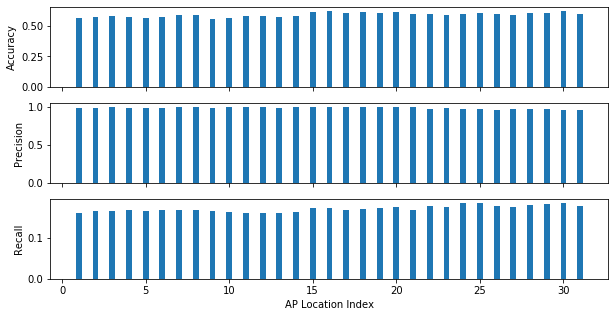

step: 16100, loss: 0.4066, Train Acc: 0.835
step: 16200, loss: 0.4382, Train Acc: 0.829
step: 16300, loss: 0.4121, Train Acc: 0.838
step: 16400, loss: 0.4426, Train Acc: 0.814
step: 16500, loss: 0.4426, Train Acc: 0.814
step: 16600, loss: 0.4265, Train Acc: 0.826
step: 16700, loss: 0.4430, Train Acc: 0.813
step: 16800, loss: 0.4457, Train Acc: 0.809
step: 16900, loss: 0.4517, Train Acc: 0.809
step: 17000, loss: 0.4211, Train Acc: 0.832
Learning rate:  [0.0370604]
Correct Y[2073]: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[2073]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.783   Accuracy(metric_all_all):  0.592 (0.592) , Precision: 0.990, Recall: 0.170
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.558  , Precision: 0.868, Recall: 0.013, metric_1_0 : 0.013
Validation Random Permutation Accuracy: 0.505


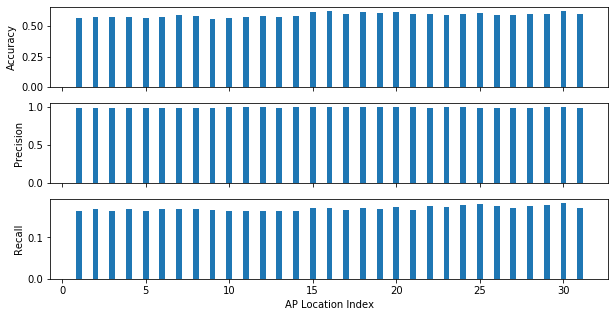

step: 17100, loss: 0.4171, Train Acc: 0.839
step: 17200, loss: 0.3876, Train Acc: 0.853
step: 17300, loss: 0.4221, Train Acc: 0.835
step: 17400, loss: 0.4142, Train Acc: 0.838
step: 17500, loss: 0.4124, Train Acc: 0.841
step: 17600, loss: 0.4143, Train Acc: 0.831
step: 17700, loss: 0.3980, Train Acc: 0.846
step: 17800, loss: 0.4567, Train Acc: 0.799
step: 17900, loss: 0.4482, Train Acc: 0.808
step: 18000, loss: 0.4292, Train Acc: 0.825
Learning rate:  [0.033354357]
Correct Y[324]: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Y[324]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.757   Accuracy(metric_all_all):  0.593 (0.593) , Precision: 0.984, Recall: 0.173
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.559  , Precision: 0.832, Recall: 0.016, metric_1_0 : 0.016
Validation Random Permutation Accuracy: 0.507


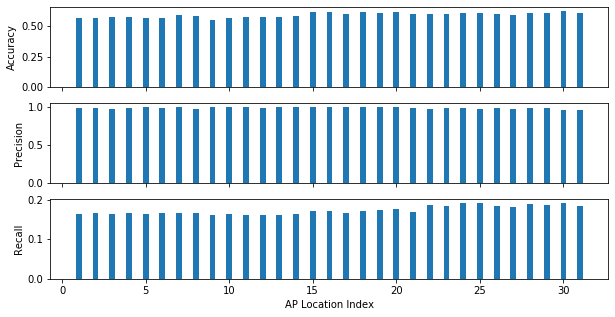

step: 18100, loss: 0.4336, Train Acc: 0.817
step: 18200, loss: 0.4453, Train Acc: 0.814
step: 18300, loss: 0.4229, Train Acc: 0.832
step: 18400, loss: 0.4353, Train Acc: 0.819
step: 18500, loss: 0.4295, Train Acc: 0.820
step: 18600, loss: 0.4328, Train Acc: 0.817
step: 18700, loss: 0.4145, Train Acc: 0.828
step: 18800, loss: 0.3988, Train Acc: 0.850
step: 18900, loss: 0.4324, Train Acc: 0.810
step: 19000, loss: 0.4729, Train Acc: 0.791
Learning rate:  [0.030018922]
Correct Y[548]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[548]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.758   Accuracy(metric_all_all):  0.594 (0.594) , Precision: 0.988, Recall: 0.174
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.560  , Precision: 0.873, Recall: 0.018, metric_1_0 : 0.018
Validation Random Permutation Accuracy: 0.506


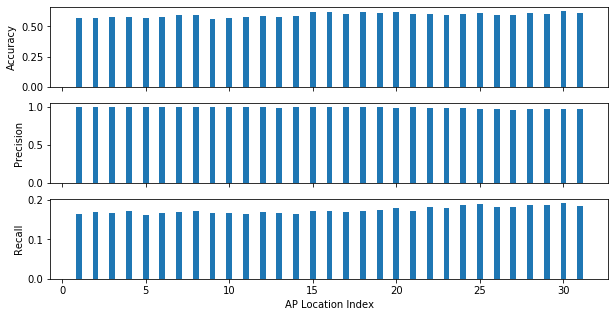

step: 19100, loss: 0.4487, Train Acc: 0.811
step: 19200, loss: 0.4499, Train Acc: 0.805
step: 19300, loss: 0.4462, Train Acc: 0.812
step: 19400, loss: 0.4808, Train Acc: 0.788
step: 19500, loss: 0.4334, Train Acc: 0.819
step: 19600, loss: 0.3895, Train Acc: 0.850
step: 19700, loss: 0.4187, Train Acc: 0.831
step: 19800, loss: 0.4519, Train Acc: 0.813
step: 19900, loss: 0.4001, Train Acc: 0.840
step: 20000, loss: 0.4221, Train Acc: 0.831
Learning rate:  [0.027017029]
Correct Y[2780]: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predicted Y[2780]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]

Validation Loss: 0.762   Accuracy(metric_all_all):  0.593 (0.593) , Precision: 0.983, Recall: 0.173
Testing only with 0 LOS input elements:  Accuracy (metric_all_0) :  0.559  , Precision: 0.819, Recall: 0.016, metric_1_0 : 0.016
Validation Random Permutation Accuracy: 0.508


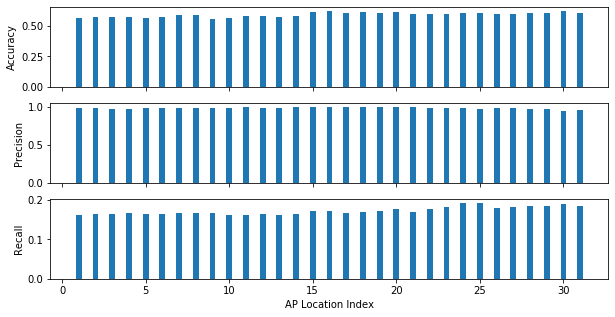

step: 20100, loss: 0.4197, Train Acc: 0.825
step: 20200, loss: 0.4655, Train Acc: 0.796
step: 20300, loss: 0.4165, Train Acc: 0.819
step: 20400, loss: 0.4673, Train Acc: 0.793
step: 20500, loss: 0.4074, Train Acc: 0.839


In [ ]:
##### session
width = 0.35

pos_acc = [0]*31
pos_precision = [0]*31
pos_recall = [0]*31
###########################
pos_acc_0 = [0]*31
pos_precision_0 = [0]*31
pos_recall_0 = [0]*31
########################
#Trying to print out the weights
# Always restart kernel before printing weights/biases
# refer: https://stackoverflow.com/questions/36193553/get-the-value-of-some-weights-in-a-model-trained-by-tensorflow
for v in tf.trainable_variables():
    #print(v.name)
    #print(v)
    if v.name == "dense/kernel:0":
        layer1weights = v
        print(layer1weights)
    if v.name == "dense/bias:0":
        layer1bias = v
        print(layer1bias)
        
    
layer1weights = [v for v in tf.trainable_variables() if v.name == "dense/kernel:0"][0]
layer1bias = [v for v in tf.trainable_variables() if v.name == "dense/bias:0"][0]

layer1weights
with tf.Session() as sess:
    sess.run(init)
    for step in range(training_epochs + 1):
        train_x, train_y = train_next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: train_x, Y: train_y})
        
        if step % display_train_step == 0 or step == 1:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: train_x, Y: train_y})
            print("step: "+str(step)+", loss: {:.4f}".format(loss)+", Train Acc: {:.3f}".format(acc))
            
        if (((step % learning_rate_iter) == 0) and (step != 0)):
            curr_learning_rate = sess.run([learning_rate])
            print("Learning rate: ", curr_learning_rate)
            sess.run(learning_rate_update, feed_dict={new_learning_rate: learning_rate_decay*curr_learning_rate[0]})

        
        if step % display_test_step == 0:
            test_x, test_y = test_next_batch()     
            val_loss, acc, p, c = sess.run([cost, accuracy, pred_labels, correct_pred], feed_dict={X: test_x, Y: test_y})
            #Printing out a random test case
            randIndex = np.random.randint(total_test_points)
            print(f"Correct Y[{randIndex}]: {test_y[randIndex,:]}")
            print(f"Predicted Y[{randIndex}]: {p[randIndex,:]}")
            
            if flag_31pts:
                for idx in range(31):
                    cmat_test = confusion_matrix(y_true=test_y[:,idx], y_pred=p[:,idx])
                    if cmat_test.size == 1:    #in case all outputs are 0s or 1s
                        tempMatrix = np.zeros((2, 2))
                        tempMatrix[0][0] = cmat_test[0]
                        cmat_test = tempMatrix
                    pos_acc[idx] = (cmat_test[0,0]+cmat_test[1,1])*1.0/(np.sum(cmat_test))
                    pos_precision[idx] = cmat_test[1,1]*1.0/(cmat_test[0,1] + cmat_test[1,1])
                    pos_recall[idx] = cmat_test[1,1]*1.0/(cmat_test[1,0] + cmat_test[1,1])
            
            cmat_test = confusion_matrix(y_true=test_y.flatten(), y_pred=p.flatten())
            total_acc = (cmat_test[0,0]+cmat_test[1,1])*1.0/(np.sum(cmat_test))
            precision = cmat_test[1,1]*1.0/(cmat_test[0,1] + cmat_test[1,1])
            recall = cmat_test[1,1]*1.0/(cmat_test[1,0] + cmat_test[1,1])
            print("\nValidation Loss: {:.3f}  \033[1m Accuracy(metric_all_all)\033[0m: \033[1m {:.3f} ({:.3f}) \033[0m, Precision: {:.3f}, Recall: {:.3f}".format(val_loss, total_acc, acc, precision, recall))
            ######################################
            ### Calculating accuracy for only the 0 LOS test cases
            
            if not(flag_preferZerosTesting):
                print(f"\033[1m Zeros are not preferred during testing Accuracy is not correct for metric_all_0 and metric_1_0!!!! \033[0m")

            zeroPresent = np.sum(test_y == 0, axis = 1)>0
            test_y_0 = test_y[zeroPresent, :]
            p_0 = p[zeroPresent, :]
            #print(f"{test_y_0.shape}\n{test_y.shape}")
            if flag_31pts:
                for idx in range(31):
                    cmat_test_0 = confusion_matrix(y_true=test_y_0[:,idx], y_pred=p_0[:,idx])
                    if cmat_test_0.size == 1:    #in case all outputs are 0s or 1s
                        tempMatrix = np.zeros((2, 2))
                        tempMatrix[0][0] = cmat_test[0]
                        cmat_test_0 = tempMatrix
                    pos_acc_0[idx] = (cmat_test_0[0,0]+cmat_test_0[1,1])*1.0/(np.sum(cmat_test_0))
                    pos_precision_0[idx] = cmat_test_0[1,1]*1.0/(cmat_test_0[0,1] + cmat_test_0[1,1])
                    pos_recall_0[idx] = cmat_test_0[1,1]*1.0/(cmat_test_0[1,0] + cmat_test_0[1,1])

            cmat_test_0 = confusion_matrix(y_true=test_y_0.flatten(), y_pred=p_0.flatten())
            #print(f"np.sum(cmat_test_0) : {np.sum(cmat_test_0)},test_y_0: {test_y_0.size}")
            total_acc_0 = (cmat_test_0[0,0]+cmat_test_0[1,1])*1.0/(np.sum(cmat_test_0))
            precision_0 = cmat_test_0[1,1]*1.0/(cmat_test_0[0,1] + cmat_test_0[1,1])
            recall_0 = cmat_test_0[1,1]*1.0/(cmat_test_0[1,0] + cmat_test_0[1,1])
            metric_1_0 = cmat_test_0[1,1]/ np.sum(test_y_0==1)
            print("Testing only with 0 LOS input elements: \033[1m Accuracy (metric_all_0) \033[0m: \033[1m {:.3f}  \033[0m, Precision: {:.3f}, Recall: {:.3f},\033[1m metric_1_0 \033[0m: {:.3f}".format( total_acc_0, precision_0, recall_0, metric_1_0))            
            ######################################
            
            
            index = list(range(test_y.shape[0]))
            shuffle(index)
            test_y_rnd = test_y[index,:]
            acc_rnd = sess.run([accuracy], feed_dict={X: test_x, Y: test_y_rnd})
            print("Validation Random Permutation Accuracy: {:.3f}".format(acc_rnd[0]))
            
            if flag_plot and flag_31pts:
                plt.rcParams['figure.figsize'] = [10, 5]
                fig, axes = plt.subplots(3, sharex=True)
                axes[0].bar(range(1,32), pos_acc, width)
                axes[1].bar(range(1,32), pos_precision, width)
                axes[2].bar(range(1,32), pos_recall, width)
                axes[2].set_xlabel('AP Location Index')
                axes[0].set_ylabel('Accuracy')
                axes[1].set_ylabel('Precision')
                axes[2].set_ylabel('Recall')
                plt.show()
    

#     print("Mean of weights from each input neuron: ")
#     for ii in range(0,157):
#         print(f"Neuron {ii}: {np.mean(sess.run(layer1weights)[ii])}")
    
#     print("Bias:")
    
#     for ii in range(0,32):
#         print(f"Neuron {ii}: {(sess.run(layer1bias)[ii])}")

 